In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import evaluation_networks as en
import contact_networks as cn
import optuna
from scipy.stats import ks_2samp
import pickle
import os
import re
import tacoma as tc
from util import plot_contact_durations, moving_average, mean_with_errors
import contact_networks as cn

/home/scho_jj/.conda/envs/pandemic_networks_env/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


# STEPS Highschool optimization

In [ ]:
class StudyWrapper():
    def __init__(self) -> None:
        self.study = optuna.create_study()
        self.stds = []

#path = 'final_results/try_3/tuned_paras_clique_loc_id=101.pkl'
#path = 'final_results/try_6/tuned_paras_clique_with_random_loc_id=101.pkl'
path = './supermarked_tuned_paras_STEPS_with_RWP_pareto_loc_id=120.pkl'
#path = 'tuned_paras_clique_with_random_loc_id=101.pkl'
#path = 'tuned_paras_STEPS_pareto_loc_id=10.pkl'
with open(path, 'rb') as file:
    SW = pickle.load(file)
    # print(SW)
    try:
        study = SW.study
    except:
        study = SW

print(study.best_value)
print(study.best_params)

from optuna.visualization.matplotlib import *
axs = plot_optimization_history(study)
plot_timeline(study)

plot_param_importances(study)
axs.set_ylim(0, 10)
#'Npps': 11, 'k': 6.719337702195763, 'STEPS_pause_min': 2681, 'STEPS_pause': 3533, 'rwp_wt_max': 2670
#'Npps': 19, 'k': 6.157907543905289, 'STEPS_pause_min': 458, 'STEPS_pause': 1008, 'rwp_wt_max': 2558

def plot_SW(SW):
    trials = SW.study.trials
    stds = SW.stds
    print(stds)

    best_vals = [trial.value for trial in trials]
    plt.errorbar(range(len(trials)), best_vals, yerr=stds, capsize=5, marker='x')
    plt.ylim(0, 20)

In [ ]:
data = []
path = 'final_results/try_6/'
for file in os.listdir(path):
    if '.pkl' not in file:
        continue

    method = file.split('paras_')[1]
    method = method.split('_loc_id')[0]
    loc_id = file.split('loc_id=')[1].split('.pkl')[0]
    
    with open(path + file, 'rb') as file:
        SW = pickle.load(file)
        try:
            study = SW.study
        except:
            study = SW

    data.append([method, loc_id, study.best_value, len(study.trials), study.best_params])

df = pd.DataFrame(data, columns=['method', 'space_per_person', 'best_score', 'n_trials', 'best_paras'])
new_df = df.pivot(index='method', columns='space_per_person', values='best_score').reset_index()
new_df['min_value'] = new_df[['3', '5', '10', '101']].apply(lambda row: row.min(), axis=1)

# Identify rows to update (method = 'random', 'baseline', 'clique', 'clique_with_random')
rows_to_update = ['random', 'baseline', 'clique', 'clique_with_random']

# Update '5' and '10' columns with values from '101' for specified rows
new_df.loc[new_df['method'].isin(rows_to_update), ['3', '5', '10']] = new_df['101']

# Sort the data frame based on the 'min_value' column
sorted_df = new_df.sort_values(by='min_value')

# Drop the 'min_value' column if you don't need it in the final result
sorted_df = sorted_df.drop(columns='min_value')

sorted_df

In [2]:
class StudyWrapper():
    def __init__(self) -> None:
        self.study = optuna.create_study()
        self.stds = []

pd.set_option('display.max_colwidth', None)      
data = []
path = 'final_results/try_12/'
for file in os.listdir(path):
    if '.pkl' not in file:
        continue

    method = file.split('paras_')[1]
    method = method.split('_loc_id')[0]
    loc_id = file.split('loc_id=')[1].split('.pkl')[0]
    loc_type = file.split('_tuned')[0]
    
    with open(path + file, 'rb') as file:
        SW = pickle.load(file)
        try:
            study = SW.study
        except:
            study = SW
    
    # Median values
    for file_median in os.listdir(f'./networks/{loc_type}/medians_many'):
            if (method in file_median) and ('.tc' in file_median) and (method[0] == file_median[0]):
                median_score = float(file_median.split('median=')[1].split('.tc')[0])
            
            


    data.append([method, loc_type, loc_id, study.best_value, median_score, len(study.trials), study.best_params])

df = pd.DataFrame(data, columns=['method', 'location', 'space_per_person', 'best_score', 'median_score', 'n_trials', 'best_paras']).sort_values(['location', 'best_score'])
df['method_alt'] = df.method.map({'STEPS_pareto': 'STEPS', 'STEPS_with_RWP_pareto': 'STEPS+RWP', 'TLW': 'TLW', 'RWP':'RWP', 'baseline': 'BASE', 'random': 'RAND', 'clique_with_random': 'CLI+RAND'})
df.sort_values(['method_alt', 'location'])

,method,location,space_per_person,best_score,median_score,n_trials,best_paras,method_alt
3,baseline,highschool,None,2.735651,3.025651,150,{'weight': 0.0002992849250132354},BASE
9,baseline,office,None,2.515045,3.005045,150,{'weight': 0.0005436035657689404},BASE
15,baseline,primaryschool,None,1.519964,1.669964,150,{'weight': 0.0013047375595401833},BASE
22,baseline,supermarked,None,3.575230,4.005230,150,{'weight': 0.009970022805909147},BASE
4,clique_with_random,highschool,None,2.197193,2.160062,150,"{'Npps': 19, 'p_space_change': 0.0562632459155923, 'mean': 170, 'sigma': 91, 'p_add': 0.008016298535436495, 'pareto_shape': 9.998054452780455}",CLI+RAND
10,clique_with_random,office,None,1.604587,1.498041,150,"{'Npps': 2, 'p_space_change': 0.026573954773857322, 'mean': 271, 'sigma': 28, 'p_add': 0.038092639210002804, 'pareto_shape': 1.592905968448615}",CLI+RAND
16,clique_with_random,primaryschool,None,0.752893,0.795460,150,"{'Npps': 9, 'p_space_change': 0.06605636980052534, 'mean': 514, 'sigma': 33, 'p_add': 0.046199106031901936, 'pareto_shape': 7.2632611210982345}",CLI+RAND
23,clique_with_random,supermarked,None,0.519769,0.735650,150,"{'Npps': 31, 'p_space_change': 0.00820944885032916, 'mean': 574, 'sigma': 43, 'p_add': 0.09139312807734347, 'pareto_shape': 2.1211790041196585}",CLI+RAND
5,random,highschool,None,2.673855,2.650406,54,"{'p_add': 0.00034618042207039445, 'pareto_shape': 7.061619041378239}",RAND
11,random,office,None,1.832385,1.721724,150,"{'p_add': 0.00045426551451094066, 'pareto_shape': 3.08156770075869}",RAND


In [25]:
df = df[['location', 'method', 'best_paras', 'median_score']]
df.to_csv('best_paras.csv')

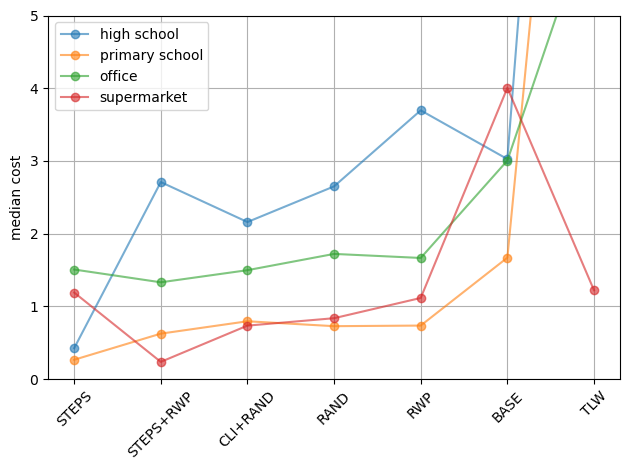

In [16]:
plt.style.use('default')
# Plotting
fig, ax = plt.subplots()

# Define custom order for x-axis
custom_order = ['STEPS', 'STEPS+RWP', 'CLI+RAND', 'RAND', 'RWP', 'BASE', 'TLW']

df['method_alt'] = pd.Categorical(df['method_alt'], categories=custom_order, ordered=True)
df = df.sort_values('method_alt')

# Grouping by location and plotting each group
for ntype in ['highschool', 'primaryschool', 'office', 'supermarked']:
#for location, group in df.groupby('location'):
    group = df[df.location == ntype]
    label = ntype
    if ntype == 'supermarked':
        label = 'supermarket'
    elif ntype == 'highschool':
        label = 'high school'
    elif ntype == 'primaryschool':
        label = 'primary school'    
    ax.plot(group['method_alt'], group['median_score'], label=label, marker='o', alpha=.6)

# Adding labels and title
#ax.set_xlabel('Method')
ax.set_ylabel('median cost')
#ax.set_title('Best Score vs Method')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adding legend
plt.legend()
plt.ylim(0, 5)
plt.grid()

plt.tight_layout()
plt.savefig('./final_plots_paper/figure2_median_cost_comp.pdf')

0.07491403716888616 [0.07491404 0.01174446 0.01473233 0.01200674 0.00861055 0.01051765
 0.00174976]
0.12082233777145308 [0.12082234 0.05141193 0.0404227  0.04416281 0.04366426 0.01925468
 0.00229945]
0.020126293149030767 [0.01777822 0.02012629 0.01788725 0.01556338 0.01608386 0.00891695
 0.00411471]
0.13382772331692203 [0.02664895 0.13382772 0.04313651 0.03788007 0.02843426 0.00792298
 0.02596597]


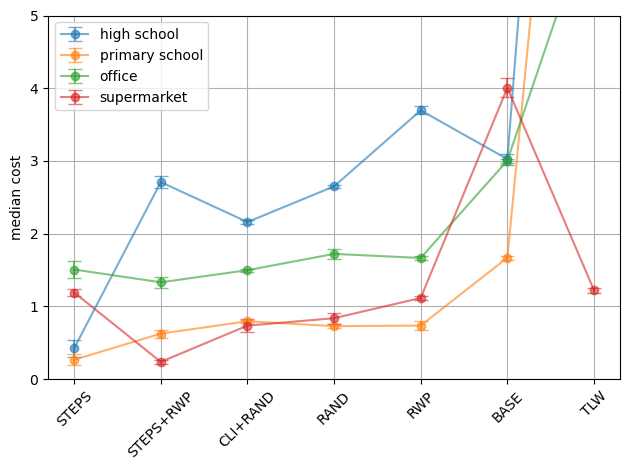

In [7]:
plt.style.use('default')
# Plotting
fig, ax = plt.subplots()

# Define custom order for x-axis
custom_order = ['STEPS', 'STEPS+RWP', 'CLI+RAND', 'RAND', 'RWP', 'BASE', 'TLW']

df['method_alt'] = pd.Categorical(df['method_alt'], categories=custom_order, ordered=True)
df = df.sort_values('method_alt')

# Grouping by location and plotting each group
for ntype in ['highschool', 'primaryschool', 'office', 'supermarked']:
#for location, group in df.groupby('location'):
    group = df[df.location == ntype]
    label = ntype
    if ntype == 'supermarked':
        label = 'supermarket'
    elif ntype == 'highschool':
        label = 'high school'
    elif ntype == 'primaryschool':
        label = 'primary school' 

    #print(group['method'].values) 
    y_error = [] 
    for method in group['method'].values:
        costs = np.load(f'./networks/{ntype}/medians_many/{method}_costs.npy') 
        median_cost = np.median(costs)

        # Calculate the median absolute deviation (MAD)
        mad = np.median(np.abs(costs - median_cost))

        # Estimate the standard error of the median
        sem_median = 1.253 * mad / np.sqrt(len(costs))

        # Calculate the 95% confidence interval for the median
        z = 1.96  # Critical value for 95% confidence interval
        y_error.append(z * sem_median)

    relative_confidence = z * sem_median / group['median_score']
    print(max(relative_confidence), relative_confidence.values)
    ax.errorbar(group['method_alt'], group['median_score'], y_error, xerr=None, label=label, marker='o', alpha=.6, capsize=5)

# Adding labels and title
#ax.set_xlabel('Method')
ax.set_ylabel('median cost')
#ax.set_title('Best Score vs Method')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adding legend
plt.legend()
plt.ylim(0, 5)
plt.grid()

plt.tight_layout()
plt.savefig('./final_plots_paper/figure2_median_cost_comp.pdf')

In [70]:
def calculate_stds(ntype, methods, smoothing=3):
    if ntype == 'office':
        capacity = 217
        path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .013, 20 / (7*24*60*60), 250, 35  # beta, gamma, nruns, ndays
        SIR_path = './results/office_empirical_beta=0.013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0005436035657689404
        N = 176

    elif ntype == 'highschool':
        capacity = 327
        path = './data_eval_split/highschool/f0_2013-12-03.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .007, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/highschool_empirical_beta=0.007_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -71, -1
        weight = 0.0002992849250132354
        N = 310

    elif ntype == 'primaryschool':
        capacity = 242
        path = './data_eval_split/primaryschool/1970-01-01.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .0013, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0013047375595401833
        N = 236

    elif ntype == 'supermarked':
        capacity = None
        path = './data_eval_split/supermarked/f0_2021-03-17.parquet'
        max_dist, min_dist, fov = 1.5, 0.0, 2*np.pi
        new_time = 20
        SIR_paras = .075, 20 / (7*24*60*60), 250, 35
        tail, tail_emp = -1, -1
        SIR_path = './results/supermarked_empirical_beta=0.075_gamma=3.306878306878307e-05.npy'
        weight = 0.009970022805909147
        N = 539
    
    path = f'./networks/{ntype}/optimized_networks/{methods}/'
    costs = []

    # Empirical Network
    tn_emp = tc.load_json_taco(f'./networks/{ntype}/empirical.taco')
    time = np.arange(tn_emp.tmax * 35 + 1)[:tail] * 20/(24*60*60)
    # Get SIR
    I_emp_mean, I_emp_error_upper, I_emp_error_lower = mean_with_errors(np.load(SIR_path), N)
    # Get Edge duration
    _, _, m_emp = tc.edge_counts(tn_emp)
    m_emp_smooth = moving_average(m_emp[:-1], smoothing) 
    # Get contact duration
    res = tc.api.measure_group_sizes_and_durations(tn_emp)  
    CD_emp = res.contact_durations

    for n in range(21):
        #print(n)
        n_str = str(n).zfill(2)
        path_network = path + f'{methods}_{n_str}_network.taco'
        path_SIR = path + f'{methods}_{n_str}_SIR.npy'
        tn = tc.load_json_taco(path_network)
        #I_mod_mean, _, _ = mean_with_errors(np.load(path_SIR), N)
        I_mod_mean =np.load(path_SIR)
        # Get Edge duration
        _, _, m = tc.edge_counts(tn)

        # Compute metrics
        # Compute SIR simularity
        time_diff = round((time[np.argmax(I_emp_mean)] - time[np.argmax(I_mod_mean)])/time[np.argmax(I_emp_mean)], 2)
        size_diff = round((np.max(I_emp_mean) - np.max(I_mod_mean)) / N, 2)
        
        # Plot edge counts
        # Edge counts
        _, _, m = tc.edge_counts(tn)
        m_smooth = moving_average(m[:-1], smoothing) 
        if methods == 'baseline':
            m = np.array(m)
            m = m * weight
        N_e_diff =round((np.sum(m_emp_smooth) - np.sum(m_smooth))/ np.sum(m_emp_smooth), 2)

        # Contact duration
        res = tc.api.measure_group_sizes_and_durations(tn)    
        ks_test = ks_2samp(res.contact_durations, CD_emp).statistic

        #print(abs(time_diff), abs(size_diff), abs(N_e_diff), abs(ks_test))
        costs.append(3*abs(time_diff) + 5*abs(size_diff) + 2*abs(N_e_diff) + abs(ks_test))
    
    costs = np.array(costs)
    #print(np.median(costs), np.std(costs))
    np.save(f'./networks/{ntype}/medians_many/{methods}_costs.npy', costs)
    return costs

for ntype in ['highschool', 'primaryschool', 'office', 'supermarked']:
    for method in ['STEPS_pareto', 'STEPS_with_RWP_pareto', 'RWP', 'TLW', 'baseline', 'random', 'clique_with_random']:
        print(ntype, method)
        calculate_stds(ntype=ntype, methods=method)

highschool STEPS_pareto


highschool STEPS_with_RWP_pareto
highschool RWP
highschool TLW
highschool baseline
highschool random
highschool clique_with_random
primaryschool STEPS_pareto
primaryschool STEPS_with_RWP_pareto
primaryschool RWP
primaryschool TLW
primaryschool baseline
primaryschool random
primaryschool clique_with_random
office STEPS_pareto
office STEPS_with_RWP_pareto
office RWP
office TLW
office baseline
office random
office clique_with_random
supermarked STEPS_pareto
supermarked STEPS_with_RWP_pareto
supermarked RWP
supermarked TLW
supermarked baseline
supermarked random
supermarked clique_with_random


In [66]:
costs = costs_STEPS
# Calculate the median
median_cost = np.median(costs)

# Calculate the median absolute deviation (MAD)
mad = np.median(np.abs(costs - median_cost))

# Estimate the standard error of the median
sem_median = 1.253 * mad / np.sqrt(len(costs))

# Calculate the 95% confidence interval for the median
z = 1.96  # Critical value for 95% confidence interval
ci_lower = median_cost - z * sem_median
ci_upper = median_cost + z * sem_median

print(costs)
print(f"Median: {median_cost}")
print(f"MAD: {mad}")
print(f"Standard Error of the Median: {sem_median}")
print(f"95% Confidence Interval: ({ci_lower}, {ci_upper})")

[1.48245143 0.71763782 0.27950779 0.56165709 0.59600475 0.43149407
 0.63178925 0.44914916 0.67569092 0.44714818 0.42985611 0.66490012
 1.41632765 0.30538296 1.05846503 0.53999147 1.03720973 1.25785589
 0.73314513 0.6746501  1.34454548]
Median: 0.6649001249441737
MAD: 0.21775194852144963
Standard Error of the Median: 0.05953926561381232
95% Confidence Interval: (0.5482031643411016, 0.7815970855472458)


In [11]:
pd.set_option('display.max_colwidth', None)
best_df_5 = df[(df.space_per_person == '101') | (df.space_per_person == '10')].sort_values(['best_score'], ascending=True).reset_index(drop=True)
best_paras_dict = {}

def extract_paras(row):
    paras = row.best_paras
    try:
        paras['N_people_per_space'] = paras.pop('Npps')
    except KeyError:
        pass

    try:
        paras['RWP_WT_MAX'] = paras.pop('rwp_wt_max')
    except KeyError:
        pass

    try:
        paras['STEPS_pause_max'] = paras.pop('STEPS_pause') + paras['STEPS_pause_min']
    except KeyError:
        pass
    
    best_paras_dict[row.method] = paras


df[df.location == 'office'].apply(extract_paras , axis=1)
best_paras_dict

{'STEPS_pareto': {'k': 2.8809814385623684,
  'STEPS_pareto': 0.7676296683599062,
  'N_people_per_space': 24},
 'STEPS_with_RWP_pareto': {'k': 5.120812726526037,
  'STEPS_pareto': 0.3463158890907987,
  'N_people_per_space': 40,
  'RWP_WT_MAX': 317},
 'clique_with_random': {'p_space_change': 0.026573954773857322,
  'mean': 271,
  'sigma': 28,
  'p_add': 0.038092639210002804,
  'pareto_shape': 1.592905968448615,
  'N_people_per_space': 2},
 'RWP': {'RWP_WT_MAX': 1797},
 'random': {'p_add': 0.00045426551451094066, 'pareto_shape': 3.08156770075869},
 'baseline': {'weight': 0.0005436035657689404},
 'TLW': {'TLW_WT_MAX': 3277,
  'TLW_WT_EXP': -0.28634300032673937,
  'FL_MAX': 49,
  'FL_EXP': -9.894483858860687}}

# Plot 2: Metriken

In [3]:
from tacoma import get_logarithmic_histogram
from collections import Counter

def plot_only_contact_durations(result,
                           ax,
                           marker=None,
                           xlabel='duration',
                           bins=100,  # number of bins
                           time_normalization_factor=1.,
                           time_unit=None,
                           bin_dt=None,
                           plot_step=False,
                           fit_power_law=False,
                           use_logarithmic_histogram=True,
                           markersize=4,
                           label=None,
                           color=None,
                           alpha=1.0
                           ):
    if marker is None:
        markers = ['o', 'x']
    else:
        markers = [marker] * 2

    if label is None:
        labels = ['contact', 'inter-contact']
    else:
        # labels = [label] * 2
        labels = label


    if bin_dt is not None:
        use_discrete_dt = True
    else:
        use_discrete_dt = False

    if not hasattr(ax,'__len__'):
        a = [ax, ax]
    else:
        a = ax

    durs = [np.array(result.contact_durations, dtype=float),
            np.array(result.group_durations[1], dtype=float)]
    res = {}

    for i, dur in enumerate(durs[:-1]):
        if not plot_step:
            if use_logarithmic_histogram:
                x, y = get_logarithmic_histogram(
                    time_normalization_factor*dur, bins)
            elif use_discrete_dt:
                c = Counter(dur / bin_dt)
                total = sum(c.values())
                x = []
                y = []
                for x_, y_ in c.items():
                    x.append(x_* bin_dt)
                    y.append(y_/total / bin_dt)
            else:
                y, x = np.histogram(dur*time_normalization_factor,bins=bins,density=True)
                x = 0.5*(x[1:]+x[:-1])
                print(x.shape,y.shape)

            a[i].plot(x, y, ls='', marker=markers[i], color=color,
                    ms=markersize,
                    mew=1,
                    mfc='None',
                    alpha=alpha,
                    label=label
                    )
        else:
            if use_logarithmic_histogram:
                x, y = get_logarithmic_histogram(
                    time_normalization_factor*dur, bins, return_bin_means=False)
            elif use_discrete_dt:
                c = Counter(dur / bin_dt)
                total = sum(c.values())
                x = []
                y = []
                for x_, y_ in c.items():
                    x.append(x_* bin_dt)
                    y.append(y_/total / bin_dt)
                x.append(x[-1]+1)
            else:
                y, x = np.histogram(dur*time_normalization_factor,bins=bins,density=True)
            a[i].step(x, np.append(y, y[-1]),
                    where='post',
                    label=labels[i],
                    color=color,
                    alpha=alpha
                    )

        res[labels[i]] = (x, y)

    if time_unit is not None:
        xlabel += ' [' + time_unit + ']'
    ylabel = 'probability density'
    if time_unit is not None:
        ylabel += ' [1/' + time_unit + ']'

    for ax in a: 
 
        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xlabel(xlabel)
        #ax.set_ylabel(ylabel)

    return res

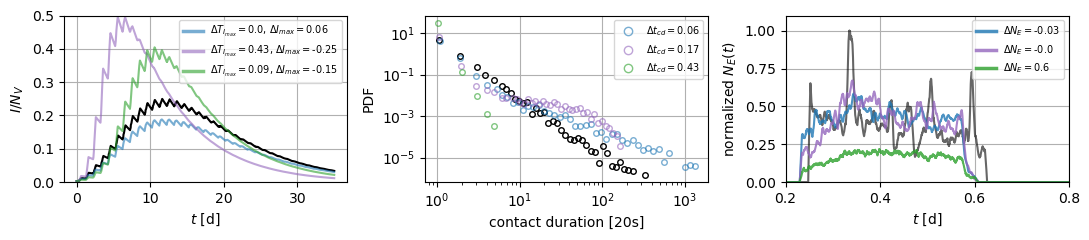

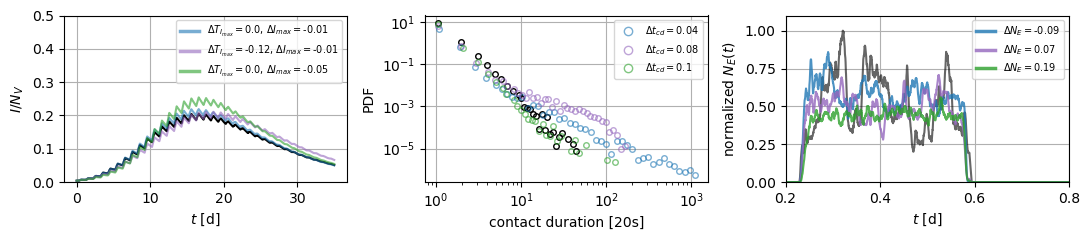

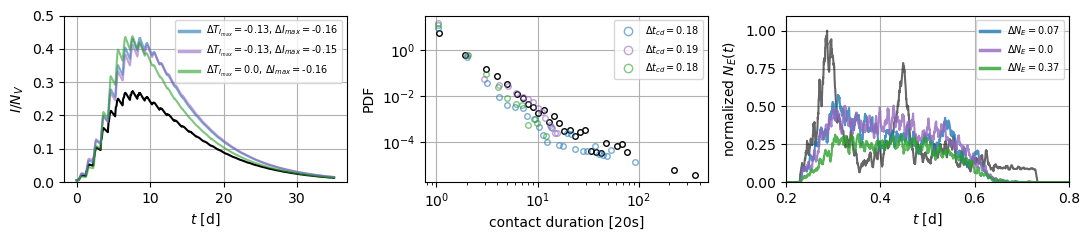

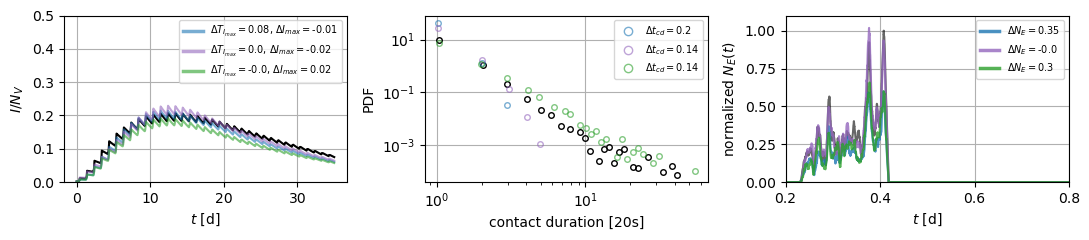

In [8]:

def plot_network_metrics(ntype, methods, axs, smoothing=20):
    colors = dict(zip(['STEPS_pareto', 'RWP', 'random', 'clique_with_random', 'STEPS_with_RWP_pareto', 'TLW', 'baseline'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
    if ntype == 'office':
        capacity = 217
        path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .013, 20 / (7*24*60*60), 250, 35  # beta, gamma, nruns, ndays
        SIR_path = './results/office_empirical_beta=0.013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0005436035657689404
        N = 176

    elif ntype == 'highschool':
        capacity = 327
        path = './data_eval_split/highschool/f0_2013-12-03.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .007, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/highschool_empirical_beta=0.007_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -71, -1
        weight = 0.0002992849250132354
        N = 310

    elif ntype == 'primaryschool':
        capacity = 242
        path = './data_eval_split/primaryschool/1970-01-01.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .0013, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0013047375595401833
        N = 236

    elif ntype == 'supermarked':
        capacity = None
        path = './data_eval_split/supermarked/f0_2021-03-17.parquet'
        max_dist, min_dist, fov = 1.5, 0.0, 2*np.pi
        new_time = 20
        SIR_paras = .075, 20 / (7*24*60*60), 250, 35
        tail, tail_emp = -1, -1
        SIR_path = './results/supermarked_empirical_beta=0.075_gamma=3.306878306878307e-05.npy'
        weight = 0.009970022805909147
        N = 539

    # axs: should be a iterable over 3 axis objects
    # For each axis, SIR, contact_duration, and edge_counts are ploted
    ax_SIR, ax_CD, ax_EC = axs

    # Load empirical network of type ntype 
    tn_emp = tc.load_json_taco(f'./networks/{ntype}/empirical.taco')
    time = np.arange(tn_emp.tmax * 35 + 1)[:tail] * 20/(24*60*60)
    # SIR
    I_emp_mean, I_emp_error_upper, I_emp_error_lower = mean_with_errors(np.load(SIR_path), N)
    ax_SIR.plot(time, I_emp_mean[:tail] / N, c='black')
    # Edge duration
    _, _, m_emp = tc.edge_counts(tn_emp)
    m_emp_smooth, t = moving_average(m_emp[:-1], smoothing) , moving_average(tn_emp.t, smoothing)
    m_max = np.max(m_emp_smooth)
    m_emp_smooth = m_emp_smooth / m_max
    ax_EC.plot(t * 20/(60**2 * 24), m_emp_smooth, color='black', alpha=.6)
    ax_SIR.set(ylabel=r'$I/N_V$', ylim=(0, .5))


    res = tc.api.measure_group_sizes_and_durations(tn_emp)  
    CD_emp = res.contact_durations
    plot_only_contact_durations(res, (ax_CD), fit_power_law=True, bins=50, xlabel='duration [min]', color='black', alpha=1.0)
    #ax_CD.set(ylabel='PDF')

    for method in methods:
        color = colors[method]
        # Load model network 
        for file in os.listdir(f'./networks/{ntype}/medians_many'):
            if (method in file) and ('.tc' in file) and (method[0] == file[0]):
                tn_mod = tc.load_json_taco(f'./networks/{ntype}/medians_many/' + file)
            if (method in file) and ('.npy' in file) and (method[0] == file[0]):
                I_mod_mean = np.load(f'./networks/{ntype}/medians_many/' + file)
        
        # Plot SIR
        # Compute simularity
        time_diff = round((time[np.argmax(I_emp_mean)] - time[np.argmax(I_mod_mean)])/time[np.argmax(I_emp_mean)], 2)
        size_diff = round((np.max(I_emp_mean) - np.max(I_mod_mean)) / N, 2)
              
        label_SIR = r'$\Delta T_{I_{max}} =$' + str(time_diff) + r', $\Delta I_{max}  =$' + str(size_diff)
        ax_SIR.plot(time, I_mod_mean[:tail_emp] / N, label=label_SIR, c=color, alpha=.6)
        
        # Plot edge counts
        # Edge counts
        _, _, m = tc.edge_counts(tn_mod)
        #m = m / m_max
        m_smooth, t = moving_average(m[:-1], smoothing) / m_max, moving_average(tn_mod.t, smoothing)
        if method == 'baseline':
            m_smooth = m_smooth * weight
        N_e_diff =round((np.sum(m_emp_smooth) - np.sum(m_smooth))/ np.sum(m_emp_smooth), 2)
        ax_EC.plot(t * 20/(60**2 * 24), m_smooth, color=color, alpha=.8, label=r'$\Delta N_E=$' + f'{N_e_diff}')

        # Contact duration
        res = tc.api.measure_group_sizes_and_durations(tn_mod)    
        ks_test = ks_2samp(res.contact_durations, CD_emp).statistic
        label_cd = r'$\Delta t_{cd}=$'+ f'{round(ks_test, 2)}'
        plot_only_contact_durations(res, (ax_CD), fit_power_law=True, bins=50, label=label_cd, xlabel='duration [min]', color=color, alpha=.6)
    
    '''if ntype == 'supermarked':
        ax_SIR.set(xlabel=r'$t$ [d]')
        ax_EC.set(xlabel=r'$t$ [h]', xlim=(5, 18))
        ax_CD.set(xlabel='contact duration [20s]')'''
    
    ax_SIR.set(xlabel=r'$t$ [d]')
    ax_EC.set(xlabel=r'$t$ [d]', xlim=(.2, .8), ylim=(0, 1.1))
    ax_CD.set(xlabel='contact duration [20s]')
    
    if ntype == 'highschool':
        offset = -.07
        '''ax_SIR.set_title(r'$I/N_V$', rotation=0, loc='left', x=offset)
        ax_EC.set_title(r'$N_E(t)$', rotation=0, loc='left', x=offset)
        ax_CD.set_title('PDF', rotation=0, loc='left', x=offset)'''

    #ax_SIR.set_ylabel(r'$I/N_V$')
    ax_EC.set_ylabel(r'normalized $N_E(t)$')
    ax_CD.set_ylabel('PDF')
    ax_EC.legend(fontsize='x-small')

for ntype in ['highschool', 'primaryschool', 'office', 'supermarked']:
    fig, axs=plt.subplots(1, 3,figsize=(11, 2.5))   
    #methods_all = ['STEPS_pareto', 'RWP', 'STEPS_with_RWP_pareto', 'TLW', 'clique_with_random', 'random', 'baseline']
    methods = ['STEPS_pareto', 'STEPS_with_RWP_pareto', 'random']

    paper_name = {'STEPS_pareto': 'STEPS', 'STEPS_with_RWP_pareto': 'STEPS+RWP', 'TLW': 'TLW', 'RWP':'RWP', 'baseline': 'BASE', 'random': 'RAND', 'clique_with_random': 'CLI+RAND'}
    colors = dict(zip(['STEPS_pareto', 'RWP', 'random', 'clique_with_random', 'STEPS_with_RWP_pareto', 'TLW', 'baseline'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
    plot_network_metrics(ntype, methods, axs)

    plt.tight_layout()
    for ax in axs.flatten():
        leg = ax.legend(fontsize=7., markerscale=1.5)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(2.5)
        ax.grid()

    plt.savefig(f'./final_plots_paper/figure4_{ntype}_STEPS_rand_comp.pdf')

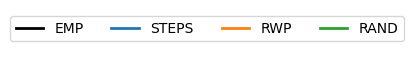

In [10]:
# Legend
fig, ax = plt.subplots(figsize=(1, .5))   
#methods_all = ['STEPS_pareto', 'RWP', 'STEPS_with_RWP_pareto', 'TLW', 'clique_with_random', 'random', 'baseline']
methods = ['STEPS_pareto', 'RWP', 'random']

paper_name = {'STEPS_pareto': 'STEPS', 'STEPS_with_RWP_pareto': 'STEPS+RWP', 'TLW': 'TLW', 'RWP':'RWP', 'baseline': 'BASE', 'random': 'RAND', 'clique_with_random': 'CLI+RAND'}
colors = dict(zip(['STEPS_pareto', 'RWP', 'random', 'clique_with_random', 'STEPS_with_RWP_pareto', 'TLW', 'baseline'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
# Create legend handles and labels
handles = [plt.Line2D([0], [0], color='black', lw=2)] + [plt.Line2D([0], [0], color=colors[method], lw=2) for method in methods]
labels = ['EMP'] + [paper_name[method] for method in methods]

# Plot legend
ax.legend(handles, labels, loc='lower center', ncol=len(labels) + 1)

# Hide the axis
ax.axis('off')
plt.tight_layout()

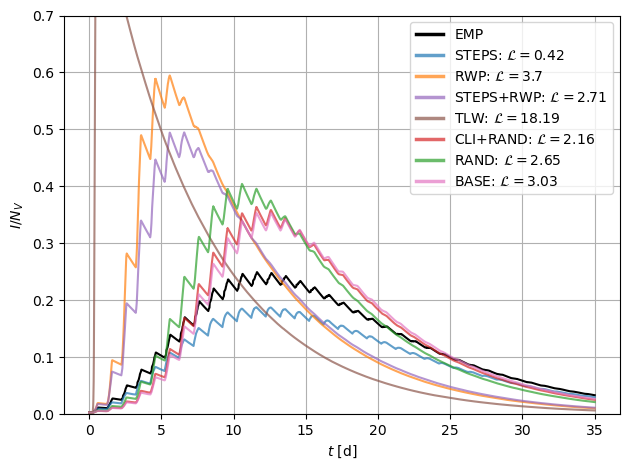

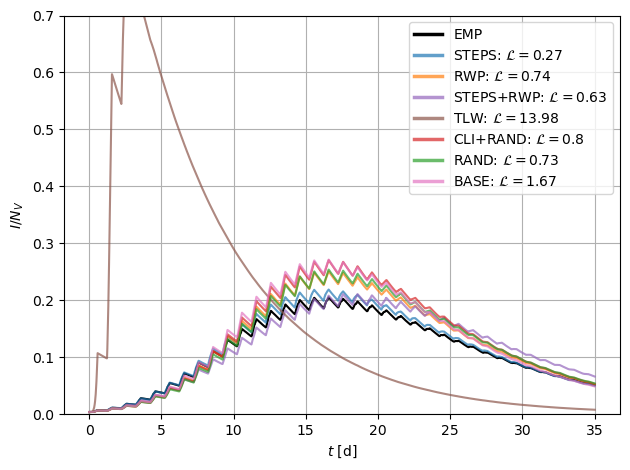

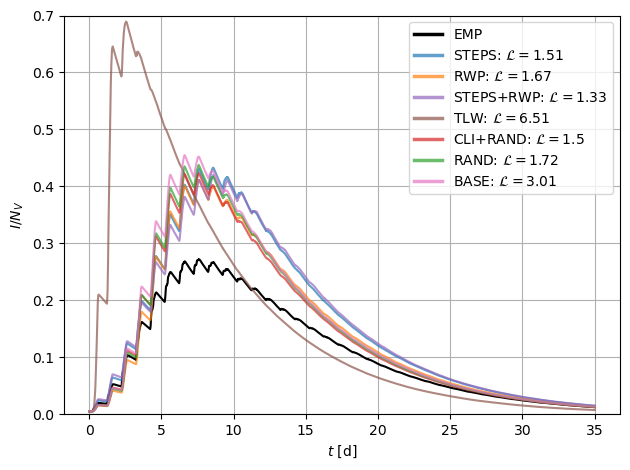

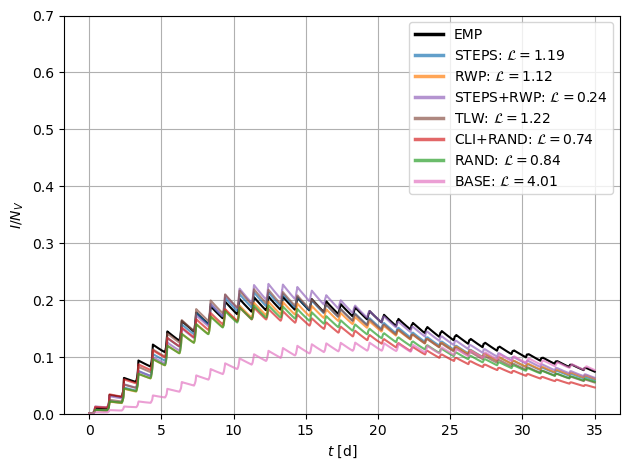

In [9]:
plt.style.use('default')

def plot_SIR(ntype, ax, methods):
    paper_name = {'STEPS_pareto': 'STEPS', 'STEPS_with_RWP_pareto': 'STEPS+RWP', 'TLW': 'TLW', 'RWP':'RWP', 'baseline': 'BASE', 'random': 'RAND', 'clique_with_random': 'CLI+RAND'}
    colors = dict(zip(['STEPS_pareto', 'RWP', 'random', 'clique_with_random', 'STEPS_with_RWP_pareto', 'TLW', 'baseline'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
    if ntype == 'office':
        capacity = 217
        path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .013, 20 / (7*24*60*60), 250, 35  # beta, gamma, nruns, ndays
        SIR_path = './results/office_empirical_beta=0.013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0005436035657689404
        N = 176

    elif ntype == 'highschool':
        capacity = 327
        path = './data_eval_split/highschool/f0_2013-12-03.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .007, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/highschool_empirical_beta=0.007_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -71, -1
        weight = 0.0002992849250132354
        N = 310

    elif ntype == 'primaryschool':
        capacity = 242
        path = './data_eval_split/primaryschool/1970-01-01.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .0013, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0013047375595401833
        N = 236

    elif ntype == 'supermarked':
        capacity = None
        path = './data_eval_split/supermarked/f0_2021-03-17.parquet'
        max_dist, min_dist, fov = 1.5, 0.0, 2*np.pi
        new_time = 20
        SIR_paras = .075, 20 / (7*24*60*60), 250, 35
        tail, tail_emp = -1, -1
        SIR_path = './results/supermarked_empirical_beta=0.075_gamma=3.306878306878307e-05.npy'
        weight = 0.009970022805909147
        N = 539

    # Load empirical network of type ntype 
    tn_emp = tc.load_json_taco(f'./networks/{ntype}/empirical.taco')
    time = np.arange(tn_emp.tmax * 35 + 1)[:tail] * 20/(24*60*60)

    # SIR
    I_emp_mean, I_emp_error_upper, I_emp_error_lower = mean_with_errors(np.load(SIR_path), N)
    ax.plot(time, I_emp_mean[:tail] / N, c='black', label='EMP')
    ax.set(ylim=(0.0, 0.7))

    for method in methods:
        color = colors[method]
        # Load model network 
        for file in os.listdir(f'./networks/{ntype}/medians_many'):
            if (method in file) and ('.tc' in file) and (method[0] == file[0]):
                tn_mod = tc.load_json_taco(f'./networks/{ntype}/medians_many/' + file)
                median_cost = float(file.split('median=')[1].split('.tc')[0])
            if (method in file) and ('.npy' in file) and (method[0] == file[0]):
                I_mod_mean = np.load(f'./networks/{ntype}/medians_many/' + file)

        # Plot SIR
        # Compute simularity
        time_diff = round((time[np.argmax(I_emp_mean)] - time[np.argmax(I_mod_mean)])/time[np.argmax(I_emp_mean)], 2)
        size_diff = round((np.max(I_emp_mean) - np.max(I_mod_mean)) / N, 2)

        #label_SIR = r'$\Delta T_{I_{max}} =$' + str(time_diff) + r', $\Delta I_{max}  =$' + str(size_diff)
        label_SIR = r'$\mathcal{L}=$' + f'{round(median_cost, 2)}'
        ax.plot(time, I_mod_mean[:tail_emp] / N, label=f'{paper_name[method]}: ' + label_SIR, c=color, alpha=.7)
        title = r'$(\arg\max (I_{emp}) - \arg\max (I_{model}))/ \arg\max (I_{emp}) =$' + str(time_diff) + r', $\max (I_{emp}) - \max (I_{model}) =$' + str(size_diff)

        ax.set(ylabel=r'$I/N_V$')
        ax.set(xlabel=r'$t$ [d]')
    '''if (ntype == 'highschool') or (ntype == 'office'):
        ax.set(ylabel=r'$I/N_V$')
    if (ntype == 'supermarked') or (ntype == 'office'):
        ax.set(xlabel=r'$t$ [d]')'''

for ntype in ['highschool', 'primaryschool', 'office', 'supermarked']:
    fig, axs = plt.subplots()       
    methods_all = ['STEPS_pareto', 'RWP', 'STEPS_with_RWP_pareto', 'TLW', 'clique_with_random', 'random', 'baseline']
    methods_selection = ['RWP', 'clique_with_random', 'baseline', 'random']
    methods = methods_all
    plot_SIR(ntype, axs, methods)
    #plot_SIR('office', axs[1, 0], methods)
    #plot_SIR('supermarked', axs[1, 1], methods)
    #plot_SIR('primaryschool', axs[0, 1], methods)

    for ax in [axs]:
        ax.grid()
        leg = ax.legend()
        for legobj in leg.legendHandles:
            legobj.set_linewidth(2.5)

    plt.tight_layout()
    plt.savefig(f'./final_plots_paper/figure3_{ntype}_SIR.pdf')

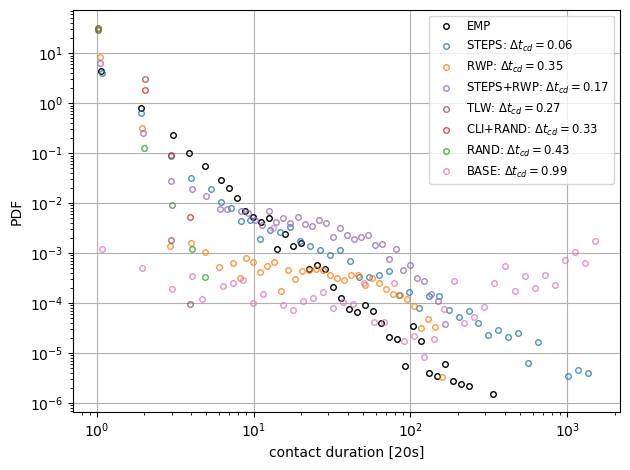

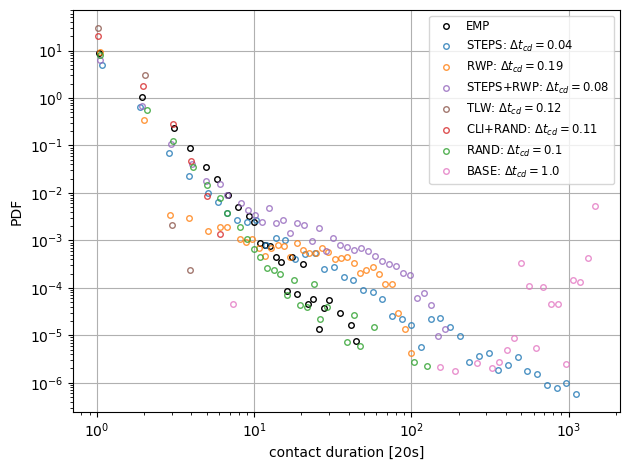

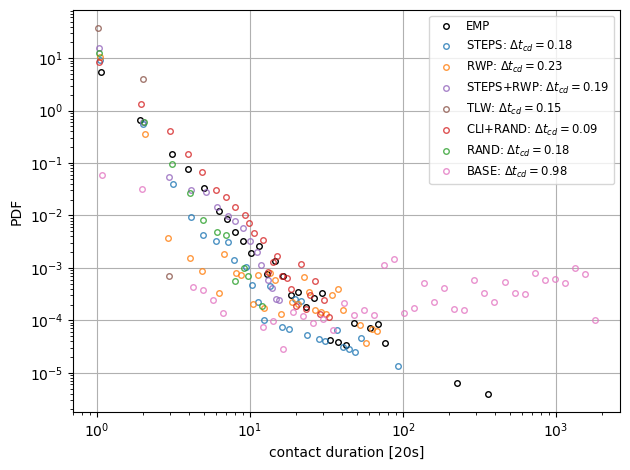

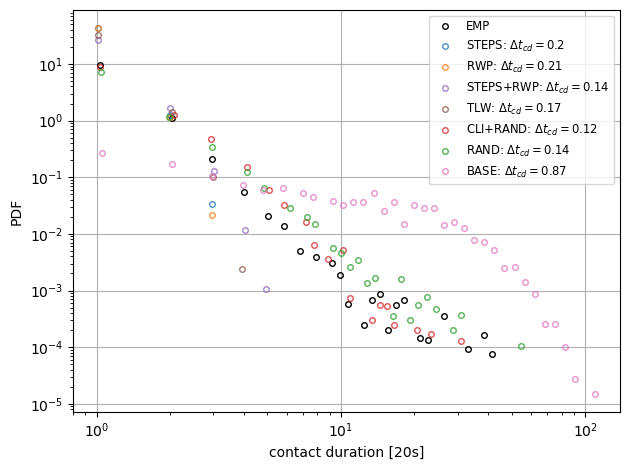

In [20]:
plt.style.use('default')

def plot_CD(ntype, ax, methods):
    paper_name = {'STEPS_pareto': 'STEPS', 'STEPS_with_RWP_pareto': 'STEPS+RWP', 'TLW': 'TLW', 'RWP':'RWP', 'baseline': 'BASE', 'random': 'RAND', 'clique_with_random': 'CLI+RAND'}
    colors = dict(zip(['STEPS_pareto', 'RWP', 'random', 'clique_with_random', 'STEPS_with_RWP_pareto', 'TLW', 'baseline'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
    if ntype == 'office':
        capacity = 217
        path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .013, 20 / (7*24*60*60), 250, 35  # beta, gamma, nruns, ndays
        SIR_path = './results/office_empirical_beta=0.013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1

    elif ntype == 'highschool':
        capacity = 327
        path = './data_eval_split/highschool/f0_2013-12-03.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .007, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/highschool_empirical_beta=0.007_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -71, -1

    elif ntype == 'primaryschool':
        capacity = 242
        path = './data_eval_split/primaryschool/1970-01-01.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .0013, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1

    elif ntype == 'supermarked':
        capacity = None
        path = './data_eval_split/supermarked/f0_2021-03-17.parquet'
        max_dist, min_dist, fov = 1.5, 0.0, 2*np.pi
        new_time = 20
        SIR_paras = .075, 20 / (7*24*60*60), 250, 35
        tail, tail_emp = -1, -1
        SIR_path = './results/supermarked_empirical_beta=0.075_gamma=3.306878306878307e-05.npy'

    # Load empirical network of type ntype 
    tn_emp = tc.load_json_taco(f'./networks/{ntype}/empirical.taco')
    time = np.arange(tn_emp.tmax * 35 + 1)[:tail] * 20/(24*60*60)
    N = tn_emp.N
    # SIR
    res = tc.api.measure_group_sizes_and_durations(tn_emp)    
    plot_only_contact_durations(res, (ax), fit_power_law=True, bins=50, xlabel='duration [min]', color='black', alpha=1.0, label='EMP')
    #ax.set(title=ntype)
    CD_emp = res.contact_durations

    for method in methods:
        color = colors[method]
        # Load model network 
        for file in os.listdir(f'./networks/{ntype}/medians_many'):
            if (method in file) and ('.tc' in file) and (method[0] == file[0]):
                tn_mod = tc.load_json_taco(f'./networks/{ntype}/medians_many/' + file)
            if (method in file) and ('.npy' in file) and (method[0] == file[0]):
                I_mod_mean = np.load(f'./networks/{ntype}/medians_many/' + file)

        # Plot CD
        res = tc.api.measure_group_sizes_and_durations(tn_mod)    
        ks_test = ks_2samp(CD_emp, res.contact_durations, alternative='two-sided')
        label = f'{paper_name[method]}: ' + r'$\Delta t_{cd}=$' + f'{round(ks_test.statistic, 2)}'
        plot_only_contact_durations(res, (ax), fit_power_law=True, bins=50, xlabel='duration [min]', color=color, alpha=.8, label=label)
    ax.set(ylabel=r'PDF')
    ax.set(xlabel='contact duration [20s]')
    '''if (ntype == 'highschool') or (ntype == 'office'):
        ax.set(ylabel=r'PDF')
    if (ntype == 'supermarked') or (ntype == 'office'):
        ax.set(xlabel='contact duration [20s]')'''

for ntype in ['highschool','primaryschool', 'office', 'supermarked']:   
    fig, axs = plt.subplots()     
    methods_all = ['STEPS_pareto', 'RWP', 'STEPS_with_RWP_pareto', 'TLW', 'clique_with_random', 'random', 'baseline']
    methods_selection = ['STEPS_pareto', 'STEPS_with_RWP_pareto', 'RWP', 'clique_with_random', 'random']
    methods = methods_all
    plot_CD(ntype, axs, methods)
    #plot_CD('office', axs[1, 0], methods)
    #plot_CD('supermarked', axs[1, 1], methods)
    #plot_CD('primaryschool', axs[0, 1], methods)

    for ax in [axs]:
        ax.grid()
        ax.legend(fontsize='small')

    plt.tight_layout()
    plt.savefig(f'./final_plots_paper/appendix1_{ntype}_cd.pdf')

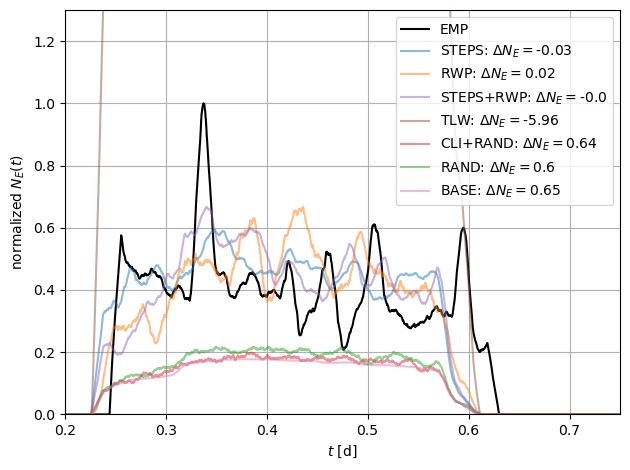

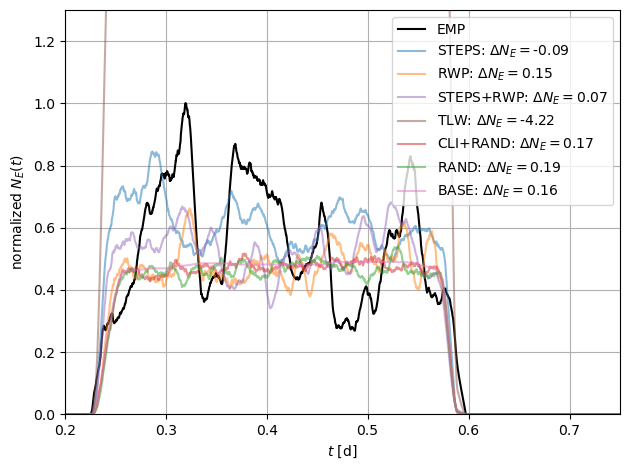

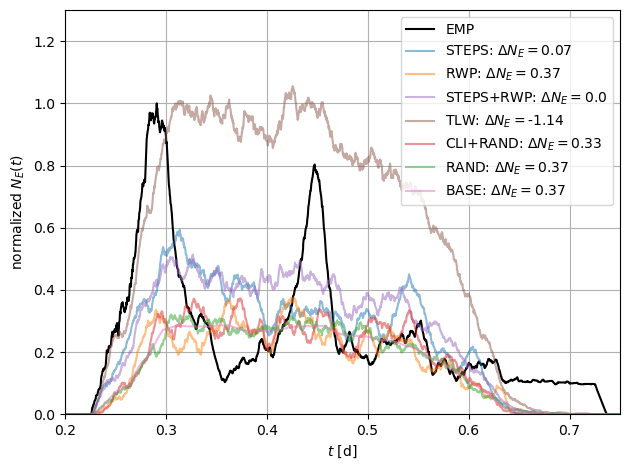

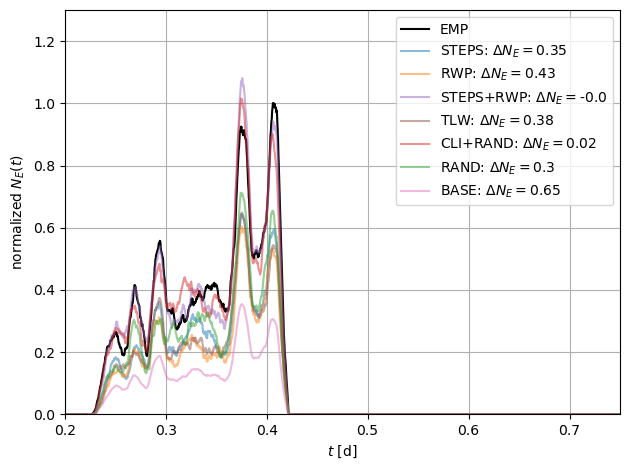

In [21]:
plt.style.use('default')

def plot_CD(ntype, ax, methods):
    smoothing = 50
    paper_name = {'STEPS_pareto': 'STEPS', 'STEPS_with_RWP_pareto': 'STEPS+RWP', 'TLW': 'TLW', 'RWP':'RWP', 'baseline': 'BASE', 'random': 'RAND', 'clique_with_random': 'CLI+RAND'}
    colors = dict(zip(['STEPS_pareto', 'RWP', 'random', 'clique_with_random', 'STEPS_with_RWP_pareto', 'TLW', 'baseline'], ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']))
    if ntype == 'office':
        capacity = 217
        path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .013, 20 / (7*24*60*60), 250, 35  # beta, gamma, nruns, ndays
        SIR_path = './results/office_empirical_beta=0.013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0005436035657689404

    elif ntype == 'highschool':
        capacity = 327
        path = './data_eval_split/highschool/f0_2013-12-03.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .007, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/highschool_empirical_beta=0.007_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -71, -1
        weight = 0.0002992849250132354

    elif ntype == 'primaryschool':
        capacity = 242
        path = './data_eval_split/primaryschool/1970-01-01.parquet'
        max_dist, min_dist, fov = 1.5, 1.0, np.pi
        SIR_paras = .0013, 20 / (7*24*60*60), 250, 35
        SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
        tail, tail_emp = -1, -1
        weight = 0.0013047375595401833

    elif ntype == 'supermarked':
        capacity = None
        path = './data_eval_split/supermarked/f0_2021-03-17.parquet'
        max_dist, min_dist, fov = 1.5, 0.0, 2*np.pi
        new_time = 20
        SIR_paras = .075, 20 / (7*24*60*60), 250, 35
        tail, tail_emp = -1, -1
        SIR_path = './results/supermarked_empirical_beta=0.075_gamma=3.306878306878307e-05.npy'
        weight = 0.009970022805909147

    # Load empirical network of type ntype 
    tn_emp = tc.load_json_taco(f'./networks/{ntype}/empirical.taco')
    time = np.arange(tn_emp.tmax * 35 + 1)[:tail] * 20/(24*60*60)
    N = tn_emp.N
    # Edge duration
    _, _, m_emp = tc.edge_counts(tn_emp)
    m_emp_smooth, t = moving_average(m_emp[:-1], smoothing), moving_average(tn_emp.t, smoothing)
    m_max = np.max(m_emp_smooth)
    m_emp_smooth = m_emp_smooth / m_max
    ax.plot(t * 20/(24*60**2), m_emp_smooth, color='black', alpha=1.0, label='EMP')
    ax.set(xlim=(.2, .75))
    ax.set(ylim=(0, 1.3))

    for method in methods:
        color = colors[method]
        # Load model network 
        for file in os.listdir(f'./networks/{ntype}/medians_many'):
            if (method in file) and ('.tc' in file) and (method[0] == file[0]):
                tn_mod = tc.load_json_taco(f'./networks/{ntype}/medians_many/' + file)
                            

       # Plot edge counts
        # Edge counts
        _, _, m = tc.edge_counts(tn_mod)
        m_smooth, t = moving_average(m[:-1], smoothing), moving_average(tn_mod.t, smoothing)
        if method == 'baseline':
            m_smooth = m_smooth * weight
            m = np.array(m) * weight
        m_smooth = m_smooth / m_max
        N_e_diff =round((np.sum(m_emp) - np.sum(m))/ np.sum(m_emp), 2)
        label = f'{paper_name[method]}: '+r'$\Delta N_E=$'+ f'{N_e_diff}'
        ax.plot(t * 20/(24*60**2), m_smooth, color=color, alpha=.5, label=label)

    ax.set(ylabel=r'normalized $N_E(t)$',)
    ax.set(xlabel=r'$t$ [d]')
    '''if (ntype == 'highschool') or (ntype == 'office'):
        ax.set(ylabel=r'normalized $N_E(t)$',)
    if (ntype == 'supermarked') or (ntype == 'office'):
        ax.set(xlabel=r'$t$ [d]')'''

for ntype in ['highschool', 'primaryschool', 'office', 'supermarked']:  
    fig, axs = plt.subplots()      
    methods_all = ['STEPS_pareto', 'RWP', 'STEPS_with_RWP_pareto', 'TLW', 'clique_with_random', 'random', 'baseline']
    methods_selection = ['clique_with_random', 'random', 'baseline']
    methods = methods_all
    #plot_CD('highschool', axs, methods)
    plot_CD(ntype, axs, methods)
    #plot_CD('supermarked', axs[1, 1], methods)
    #plot_CD('primaryschool', axs[0, 1], methods)

    for ax in [axs]:
        ax.grid()
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(f'./final_plots_paper/appendix2_{ntype}_normalized_edge_counts.pdf')

# TAPAS comparisson

In [2]:
# Load TAPAS data
df_berlin = pd.read_csv('./VF_data/pandemos_tra_tapas_modell.csv')
df_rns = pd.read_csv('./VF_data/region_niedersachsen_tapas_modell.csv')

In [3]:
# Load activity data
df_activities = pd.read_csv('./VF_data/activities.csv')
#df_activities[['id', 'code_mct', 'name_mct', 'code_tapas', 'name_tapas', 'code_zbe', 'name_zbe']].sort_values('code_zbe')

In [4]:
# Caculate cumulative location duration and and number of unique nodes
df_berlin = df_berlin[(df_berlin.loc_id_end < 100_000_000) & (df_berlin.loc_id_end >= 0)] # remove households
df_rns = df_rns[(df_rns.loc_id_end < 100_000_000) & (df_rns.loc_id_end >= 0)] # remove households

def location_specs(df):
    result = df.groupby('loc_id_end').agg({
        'activity': lambda x: x.mode().iloc[0],  # Most frequent activity
        'p_id': 'nunique',  # Unique nodes
        'activity_duration_min': ['sum', 'mean']  # Total time, mean time

    }).reset_index()

    # Rename columns 
    result.columns = ['loc_id_end', 'most_frequent_activity',  'unique_nodes', 'total_time', 'mean_time']
    return result

loc_specs_berlin = location_specs(df_berlin)
loc_specs_rns = location_specs(df_rns)

In [5]:
def total_time_and_nnodes(EN):
    # Empirical network
    EN.to_tacoma_tn()
    tn = EN.tn

    # Compute total time
    duration = EN.df_trajectories.activity_end_min - EN.df_trajectories.activity_start_min
    total_time = round(np.sum(duration) * 20/60)

    # Number of nodes
    nnodes = tn.N
    return total_time, nnodes

def get_closest_locations(result, nnodes, total_time, activity_code, nsmallest=10):
    # Assuming result is your DataFrame
    given_unique_nodes = nnodes  # Replace with your desired value
    given_total_time = total_time  # Replace with your desired value

    # Calculate the absolute relative differences
    result['diff_unique_nodes'] = abs((result['unique_nodes'] - given_unique_nodes) / given_unique_nodes)
    result['diff_total_time'] = abs((result['total_time'] - given_total_time) / given_total_time)

    # Calculate the combined absolute relative differences
    result['combined_diff'] = result['diff_unique_nodes'] + result['diff_total_time']

    # Find the top 5 closest rows
    result = result[result.most_frequent_activity == activity_code]
    closest_rows = result.nsmallest(nsmallest, 'combined_diff')

    return closest_rows  # RNS: 209315, 209385

In [6]:
# Get the location ids of n locations that are the most similar to a given empirical network
def closest_TAPAS_locations_id(ntype, nsmallest):
    sot = 2000
    new_time = None
    if ntype == 'office':
        path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
        activity_code = 212
    if ntype == 'highschool':
        path = './data_eval_split/highschool/f0_2013-12-03.parquet'
        activity_code = 410
    if ntype == 'primaryschool':
        path = './data_eval_split/primaryschool/1970-01-01.parquet'
        activity_code = 410
    if ntype == 'supermarked':
        path = './data_eval_split/supermarked/f0_2021-03-17.parquet'
        new_time = 20
    
    EN_HS = en.EvaluationNetwork(ntype, path=path, TU=20, temporal_offset=1000, switch_off_time=sot, new_time=new_time)  # switch of nodes that have no links for at least 30min
    total_time_hs, nnodes_hs = total_time_and_nnodes(EN_HS)
    closest_hs = get_closest_locations(loc_specs_rns, nnodes_hs, total_time_hs, activity_code=activity_code, nsmallest=nsmallest)
    closest_hs = closest_hs[closest_hs.most_frequent_activity == 410]

    return closest_hs.loc_id_end.values, closest_hs.unique_nodes.values

closest_TAPAS_locations_id('primaryschool', 10)

edge list errors:  0
edge changes errors:  0


(array([ 20143,   5091,  65315, 101147,   4330,  96598, 104565,   4272,
          4297,   4634]),
 array([247, 254, 259, 244, 271, 274, 246, 236, 245, 313]))

In [ ]:
def tapas_networks_make_SIR_runs(ntype, nsmallest, method='STEPS_pareto'):
    # Get SIR paras
    if method != 'STEPS_pareto':
        print('Only tested with STEPS_pareto')
        return
    
    if ntype == 'office':
        capacity = 217
        path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
        max_dist, min_dist, fov = 1.5, 0.0, 2.094395
        SIR_paras = .013, 20 / (7*24*60*60), 2170, 35  # beta, gamma, nruns, ndays
        SIR_path = './results/office_empirical_beta=0.013_gamma=3.306878306878307e-05.npy'

    elif ntype == 'highschool':
        capacity = 327
        path = './data_eval_split/highschool/f0_2013-12-03.parquet'
        max_dist, min_dist, fov = 1.5, 0.0, 2.094395
        SIR_paras = .007, 20 / (7*24*60*60), 3270, 35
        SIR_path = './results/highschool_empirical_beta=0.007_gamma=3.306878306878307e-05.npy'

    elif ntype == 'primaryschool':
        path = './data_eval_split/primaryschool/1970-01-01.parquet'
        capacity = 242
        max_dist, min_dist, fov = 1.5, 0.0, 2.094395
        SIR_paras = .0013, 20 / (7*24*60*60), 2420, 35
        SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
    
    beta, gamma, nruns, ndays = SIR_paras

    # Get best parameters for given network type and method
    best_paras_dict = {'office': {'STEPS_pareto': {'k': 2.8809814385623684,
                                    'STEPS_pareto': 0.7676296683599062,
                                    'N_people_per_space': 24},
                                    'STEPS_with_RWP_pareto': {'k': 4.372608807670108,
                                    'STEPS_pareto': 0.7189126397421236,
                                    'N_people_per_space': 30,
                                    'RWP_WT_MAX': 1177},
                                    'clique_with_random': {'p_space_change': 0.026573954773857322,
                                    'mean': 271,
                                    'sigma': 28,
                                    'p_add': 0.038092639210002804,
                                    'pareto_shape': 1.592905968448615,
                                    'N_people_per_space': 2},
                                    'random': {'p_add': 0.00045426551451094066, 'pareto_shape': 3.08156770075869},
                                    'RWP': {'RWP_WT_MAX': 1797},
                                    'baseline': {'weight': 0.0005436035657689404},
                                    'TLW': {'TLW_WT_MAX': 3277,
                                    'TLW_WT_EXP': -0.28634300032673937,
                                    'FL_MAX': 49,
                                    'FL_EXP': -9.894483858860687}},
                        
                        'primaryschool': {'STEPS_pareto': {'k': 9.974003647535408,
                                            'STEPS_pareto': 0.6130675933667971,
                                            'N_people_per_space': 39},
                                            'STEPS_with_RWP_pareto': {'k': 8.202328300072152,
                                            'STEPS_pareto': 0.6998265484241938,
                                            'N_people_per_space': 5,
                                            'RWP_WT_MAX': 1133},
                                            'clique_with_random': {'p_space_change': 0.06605636980052534,
                                            'mean': 514,
                                            'sigma': 33,
                                            'p_add': 0.046199106031901936,
                                            'pareto_shape': 7.2632611210982345,
                                            'N_people_per_space': 9},
                                            'random': {'p_add': 0.0009190357020863638, 'pareto_shape': 2.455624393138444},
                                            'RWP': {'RWP_WT_MAX': 2108},
                                            'baseline': {'weight': 0.0013047375595401833},
                                            'TLW': {'TLW_WT_MAX': 2307,
                                            'TLW_WT_EXP': -0.6106044193554402,
                                            'FL_MAX': 85,
                                            'FL_EXP': -8.996563363396556}},
                        
                        'highschool':  {'STEPS_pareto': {'k': 4.3879605793130265,
                                        'STEPS_pareto': 0.4210183226476539,
                                        'N_people_per_space': 27},
                                        'STEPS_with_RWP_pareto': {'k': 4.86415873950932,
                                        'STEPS_pareto': 0.6189274019207999,
                                        'N_people_per_space': 2,
                                        'RWP_WT_MAX': 3324},
                                        'clique_with_random': {'p_space_change': 0.0562632459155923,
                                        'mean': 170,
                                        'sigma': 91,
                                        'p_add': 0.008016298535436495,
                                        'pareto_shape': 9.998054452780455,
                                        'N_people_per_space': 19},
                                        'random': {'p_add': 0.00034618042207039445,
                                        'pareto_shape': 7.061619041378239},
                                        'RWP': {'RWP_WT_MAX': 3599},
                                        'baseline': {'weight': 0.0002992849250132354},
                                        'TLW': {'TLW_WT_MAX': 2359,
                                        'TLW_WT_EXP': -0.5029329300743824,
                                        'FL_MAX': 80,
                                        'FL_EXP': -9.987833730779137}},
                        
                        'supermarked': {'STEPS_pareto': {'k': 3.6003296257524102,
                                        'STEPS_pareto': 0.46942379903047576,
                                        'N_people_per_space': 40},
                                        'RWP': {'RWP_WT_MAX': 610},
                                        'random': {'p_add': 0.009703836159227257, 'pareto_shape': 1.4881299058280244},
                                        'STEPS_with_RWP_pareto': {'k': 3.14003379565969,
                                        'STEPS_pareto': 1.6980257805820058,
                                        'N_people_per_space': 1,
                                        'RWP_WT_MAX': 3343},
                                        'TLW': {'TLW_WT_MAX': 1478,
                                        'TLW_WT_EXP': -6.288970594712486,
                                        'FL_MAX': 54,
                                        'FL_EXP': -9.763394702496802},
                                        'clique_with_random': {'p_space_change': 0.06713118209401989,
                                        'mean': 194,
                                        'sigma': 1,
                                        'p_add': 0.08438360458727655,
                                        'pareto_shape': 0.10588878039329785,
                                        'N_people_per_space': 39},
                                        'baseline': {'weight': 0.009970022805909147}}
                            
                            
                            
                            
                            }
    best_paras = best_paras_dict[ntype][method]
    
    # Get closest locations
    location_ids, Ns_tapas = closest_TAPAS_locations_id(ntype, nsmallest)
    print(location_ids)

    try:
        Npps = best_paras['N_people_per_space']
        del best_paras['N_people_per_space']
    except KeyError:
        Npps = 20

    for i, (locaction_id, N_tapas) in enumerate(zip(location_ids, Ns_tapas)):
        # Load trajectories
        df_base = df_rns[df_rns.loc_id_end == locaction_id][['p_id', 'activity_start_min', 'loc_id_end', 'activity_duration_min']]
        df_base['activity_end_min'] = df_base.activity_start_min + df_base.activity_duration_min
        #t_start, t_end = df_base.activity_start_min.min(), df_base.activity_end_min.max()
        #print(df_base)
        #print(t_start, t_end)
        t_start, t_end = 0, 1440 # Simulate one day in minutes

        # Build location
        # Try to find Npps in best paras, if this fails set to 20 (in that case it should be of no importance to the method)

        print(Npps, N_tapas)
        Loc = cn.build_location(df_base, 'tapas_' + ntype, ntype, N_pps=Npps, capacity=N_tapas) 

        # Build network
        CN = cn.ContactNetwork(df_base.copy(), Loc, t_start, t_end, time_scale_data=60)
        for para, para_value in best_paras.items():
            CN.__setattr__(para, para_value)
        
        CN.change_fov(fov)
        #CN.make_movement(method)
        #CN.make_tacoma_network(min_dist=min_dist, max_dist=max_dist, time_resolution=20, temporal_offset=0)
        try:
            CN.make_movement(method)
            CN.make_tacoma_network(min_dist=min_dist, max_dist=max_dist, time_resolution=20, temporal_offset=0)
        except Exception as e:
            print(e)
            continue

        # Run SIR
        save_path = f'./results/tapas_SIR_runs/{ntype}/{method}/{ntype}_tapas_id={locaction_id}_best={str(i).zfill(3)}_Ntapas={N_tapas}.npy'
        save_path_net = f'./results/tapas_SIR_runs/{ntype}/{method}/{ntype}_tapas_id={locaction_id}_best={str(i).zfill(3)}_Ntapas={N_tapas}.taco'
        cn.run_SIR(CN.tn, Loc, method, nruns, beta, gamma, ndays, normalize=False, save=True, plot=False, save_path=save_path)
        tc.write_json_taco(CN.tn, save_path_net)

        
#tapas_networks_make_SIR_runs('primaryschool', nsmallest=30, method='STEPS_pareto')

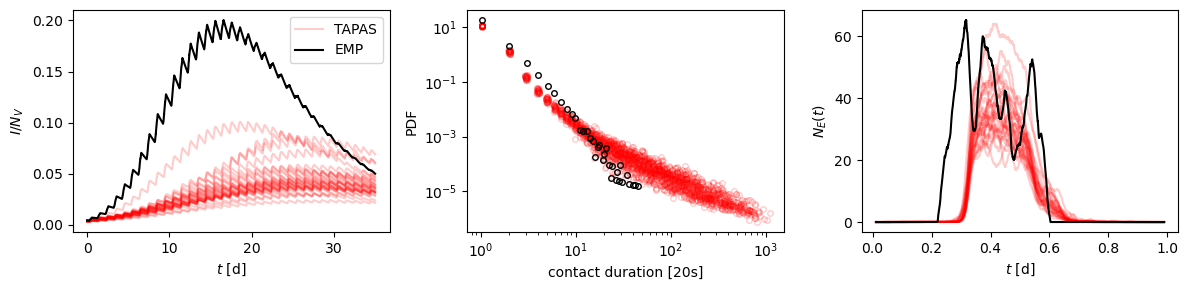

In [10]:
def plot_TAPAS_SIR_runs(method, ntype):
    if ntype == 'primaryschool':
            capacity, N_tapas = 242, 247
            SIR_paras = .0013, 20 / (7*24*60*60), 250, 35
            SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
            SIR_path_tapas = f'./results/tapas_primaryschool_{method}_beta=0.0013_gamma=3.306878306878307e-05.npy'
            tail, tail_emp = -1, -1
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    tn_emp = tc.load_json_taco('./networks/primaryschool/empirical.taco')

    I_emp, _, _ = mean_with_errors(np.load(SIR_path), capacity) 
    I_emp = I_emp / capacity
    time = np.arange(0, len(I_emp)) * 20 /(24*60**2)
    
    label = 'TAPAS'

    for file in os.listdir(f'./results/tapas_SIR_runs/{ntype}/{method}'):
        if file[-1] == 'y':
            N_tapas = int(file.split('Ntapas=')[1].split('.npy')[0])
            I_mod, _, _ = mean_with_errors(np.load(f'./results/tapas_SIR_runs/{ntype}/{method}/' + file), N_tapas) 
            #print(I_mod)
            I_mod = I_mod / N_tapas
            axs[0].plot(time, I_mod, color='red', alpha=.2, label=label)
            label=None
        
        else:
             pass
             tn = tc.load_json_taco(f'./results/tapas_SIR_runs/{ntype}/{method}/' + file)
             _, _, m = tc.edge_counts(tn)
             m = moving_average(m, 100)
             t = moving_average(tn.t, 100)
             axs[2].plot(t* 20/(24*60**2), m[:-1], color='red', alpha=.2)
             res = tc.measure_group_sizes_and_durations(tn)
             plot_only_contact_durations(res, axs[1],color='red', alpha=.2)
    
    axs[0].plot(time, I_emp, label='EMP', color='black')
    _, _, m = tc.edge_counts(tn_emp)
    m = moving_average(m, 100)
    t = moving_average(tn_emp.t, 100)
    axs[2].plot(t* 20/(24*60**2), m[:-1], color='black', alpha=1.0)
    res = tc.measure_group_sizes_and_durations(tn_emp)
    plot_only_contact_durations(res, axs[1],color='black', alpha=1.0)


    axs[0].legend()
    axs[0].set(xlabel=r'$t$ [d]', ylabel=r'$I/N_V$')
    axs[1].set(xlabel='contact duration [20s]', ylabel='PDF')
    axs[2].set(xlabel=r'$t$ [d]', ylabel=r'$N_E(t)$')
plot_TAPAS_SIR_runs('STEPS_pareto', 'primaryschool')
plt.tight_layout()

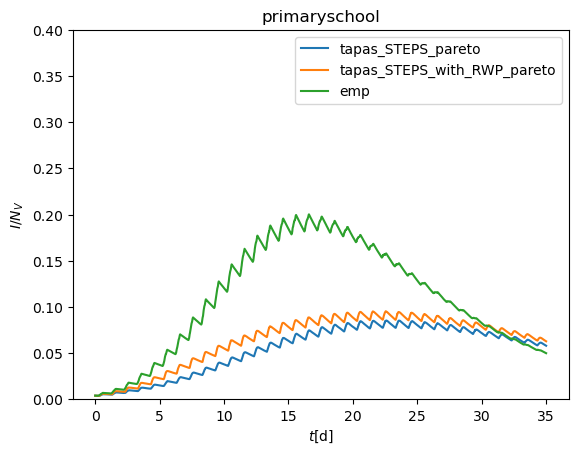

In [53]:
def tapas_emp_SIR_comparisson(methods, ntype):
    for method in methods:

        if ntype == 'office':
            capacity, N_tapas = 217, 202
            path = './data_eval_split/InVS/f1_1970-01-01.parquet' 
            max_dist, min_dist, fov = 1.5, 1.0, np.pi
            SIR_paras = .013, 20 / (7*24*60*60), 250, 35  # beta, gamma, nruns, ndays
            SIR_path = './results/office_empirical_beta=0.013_gamma=3.306878306878307e-05.npy'
            SIR_path_tapas = f'./results/tapas_office_{method}_beta=0.013_gamma=3.306878306878307e-05.npy'
            tail, tail_emp = -1, -1

        elif ntype == 'highschool':
            capacity, N_tapas = 327, 327
            path = './data_eval_split/highschool/f0_2013-12-03.parquet'
            max_dist, min_dist, fov = 1.5, 1.0, np.pi
            SIR_paras = .007, 20 / (7*24*60*60), 250, 35
            SIR_path = './results/highschool_empirical_beta=0.007_gamma=3.306878306878307e-05.npy'
            SIR_path_tapas = f'./results/tapas_highschool_{method}_beta=0.007_gamma=3.306878306878307e-05.npy'
            tail, tail_emp = -1, -71

        elif ntype == 'primaryschool':
            capacity, N_tapas = 242, 247
            path = './data_eval_split/primaryschool/1970-01-01.parquet'
            max_dist, min_dist, fov = 1.5, 1.0, np.pi
            SIR_paras = .0013, 20 / (7*24*60*60), 250, 35
            SIR_path = './results/primaryschool_empirical_beta=0.0013_gamma=3.306878306878307e-05.npy'
            SIR_path_tapas = f'./results/tapas_primaryschool_{method}_beta=0.0013_gamma=3.306878306878307e-05.npy'
            tail, tail_emp = -1, -1

        elif ntype == 'supermarked':
            capacity = None
            path = './data_eval_split/supermarked/f0_2021-03-17.parquet'
            max_dist, min_dist, fov = 1.5, 0.0, 2*np.pi
            new_time = 20
            SIR_paras = .075, 20 / (7*24*60*60), 250, 35
            tail, tail_emp = -1, -1
            SIR_path = './results/supermarked_empirical_beta=0.075_gamma=3.306878306878307e-05.npy'
        
        I_tapas, _, _ = mean_with_errors(np.load(SIR_path_tapas), N_tapas)
        I_tapas = I_tapas[:tail] / N_tapas
        time = np.arange(len(I_tapas)) * 20/(24*60**2)

        
        plt.plot(time, I_tapas, label=f'tapas_{method}')
        

    I_emp, _, _ = mean_with_errors(np.load(SIR_path), capacity)
    I_emp = I_emp[:tail_emp] / capacity
    plt.plot(time, I_emp, label='emp')
    plt.legend()
    plt.ylim(0, .4)
    plt.title(ntype)
    plt.xlabel(r'$t$[d]')
    plt.ylabel(r'$I/N_V$')

tapas_emp_SIR_comparisson(['STEPS_pareto', 'STEPS_with_RWP_pareto'], 'primaryschool')

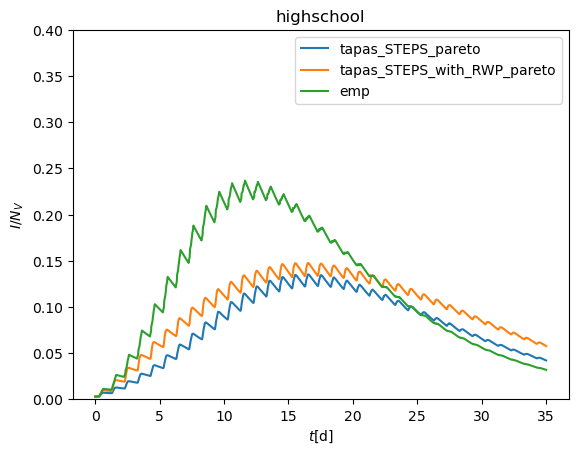

In [54]:
tapas_emp_SIR_comparisson(['STEPS_pareto', 'STEPS_with_RWP_pareto'], 'highschool')

<br>
<br><br><br><br><br><br><br><br><br><br><br><br>

# Hannah Geburtstag 2023

In [33]:
Theaterticket = 20
Bar = 65
Nepalese = 140
Bar_Essen_pp = Bar / 5 + Nepalese / 6
Hannah_Geschenk = (Theaterticket + Bar_Essen_pp) / 5

print(f'Samu: {Theaterticket + Bar_Essen_pp}€')  # schenkt nicht mit
print(f'Carls: {Hannah_Geschenk}€')  # zanlt nur Hannahs Geschenk, war nicht da
print(f'Johann: {Hannah_Geschenk + Nepalese / 6 - 4}€')  # war nicht in der bar und hat ticket gezahlt aber 4€ extra
print(f'Mascha, David, Jurij: {Hannah_Geschenk + Bar_Essen_pp + Theaterticket}€')

Samu: 56.33333333333333€
Carls: 11.266666666666666€
Johann: 30.599999999999994€
Mascha, David, Jurij: 67.6€


# Hannah Geburtstag 2024

In [39]:
Vase = 65
Blumen = 35
Karte = 2
Pro_Person = (Vase + Blumen + Karte) / 7

print(f'Pro Person: {Pro_Person}€')

Pro Person: 14.571428571428571€


In [4]:
arr = np.random.randint(0, 100, 10)
print(arr)
print(np.argsort(arr))
arr[np.argsort(arr)]

[45 95 50 33 75 89 91 78 36 33]
[3 9 8 0 2 4 7 5 6 1]


array([33, 33, 36, 45, 50, 75, 78, 89, 91, 95])

(array([0.00000000e+00, 7.57430201e-01, 1.36395477e-01, 4.97348144e-02,
        2.02141499e-02, 1.06074252e-02, 5.20364255e-03, 4.70329230e-03,
        4.00280196e-03, 2.30161113e-03, 1.90133093e-03, 1.40098069e-03,
        8.00560392e-04, 7.00490343e-04, 1.20084059e-03, 2.00140098e-04,
        7.00490343e-04, 4.00280196e-04, 3.00210147e-04, 0.00000000e+00,
        2.00140098e-04, 1.00070049e-04, 1.00070049e-04, 1.00070049e-04,
        0.00000000e+00, 2.00140098e-04, 0.00000000e+00, 3.00210147e-04,
        1.00070049e-04, 1.00070049e-04, 1.00070049e-04, 1.00070049e-04,
        0.00000000e+00, 0.00000000e+00, 1.00070049e-04, 2.00140098e-04,
        0.00000000e+00, 1.00070049e-04, 0.00000000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39.]),
 <BarContainer object of 39 artists>)

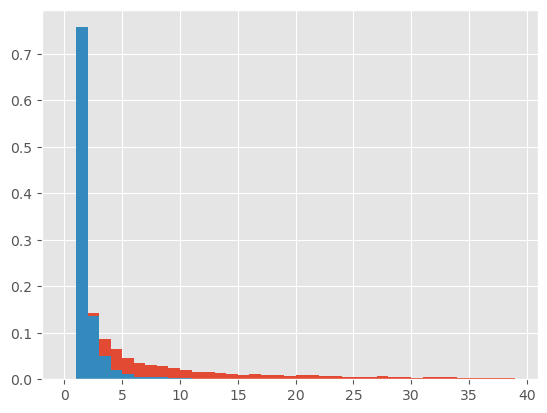

In [287]:
import random

samples_s = [random.paretovariate(0.3749733654740858) for i in range(10_000)]
samples_h = [random.paretovariate(2) for i in range(10_000)]

plt.hist(samples_s, bins=np.arange(0, 40, 1), density=True)
plt.hist(samples_h, bins=np.arange(0, 40, 1), density=True)